#线性关系（1）
####author:leftchen
##引用以及更多课程：
www.quantopian.com/lectures




 线性回归是一种测量两个或者多个变量之间的关系的模型工具。举例来说，如果想知道小明学习数学时间和他数学考试成绩之间的关系，假设这组关系是线性的，那么我们就可以设计一个初始模型: Y(数学考试成绩） = a（初始成绩） + b * X（学习数学时间）。在这个模型里，a代表了小明的初始成绩，换句话说，这代表了即使小明平常不学习数学，他也能获得的成绩。
 
 通过对原始数据处理并计算，我们可以得到模型中a（初始成绩）和b（数学考试成绩/每单位学习时间），然后通过测试新的自变量（在这里是学习数学时间）去预测或者分析小明将要取得的数学成绩。


实际上任何两组数据都能获得一个线性关系。比如我们可以用Y(数学考试成绩） = a（初始成绩） + b * X（每周吃火锅次数）来猜想吃的火锅次数和小明数学成绩之间的关系。但是，不是每组数据之间都有明确的因果联系。有的时候我们可以得到一个明确的模型，但实际上两组数据之间是毫无逻辑关系的（参考以上例子）


与此同时，数据与数据之间不一点定是线性关系，也有可能是非线性关系。比如圆面积和半径之间的关系就是非线性的(Squre = pi * r^2)。因此为了更好的解释两组数据之间的关系，我们需要不断的变换模型（多变量，非线性，取对数...），并且借助其他指标（R^2, p value, F value）去确定以及评估我们模型是否准确，或者能否很好的解释变量之间的关系。

In [5]:
%matplotlib inline
#import 我们需要的模块
import numpy as np
from statsmodels import regression # 回归
import statsmodels.api as sm
import matplotlib.pyplot as plt #画图
import math
import tushare as ts


下面我们把线性回归的用法打包做成个function

In [38]:
def linreg(X,Y):
    #线性回归
    X = sm.add_constant(X) # 为模型增加不变量，也就是上文提到的'a'
    model = regression.linear_model.OLS(Y, X).fit() #Y是因变量，X是自变量, .fit()是计算得到a和b的值
    a = model.params[0]#model.params里存贮了模型的系数
    b = model.params[1]
    X = X[:, 1]#因为在第一步里，我们改变了X的维度，这一步再把X变回来


    # 画图
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # 散点图标示原始点
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # 增加回归线
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    plt.gcf().set_size_inches(15,8)
    return model

写好function，下面我们去做点有意思的研究，去测试线性回归模型

数据来自于tushare，近两年的上证指数以及相关数据。提取出指数和交易量两组数据，我们验证的目标是：前一天的交易量的变化是否会对第二天上证指数涨跌幅有所影响

In [84]:

start = "2014-03-01"
end = "2016-03-01"
SH = ts.get_hist_data('sh', start = start, end = end, ktype = 'D')
SH = SH.iloc[::-1]#将数据时间变成从远期到近期
SH_Close = SH.close #获得上证指数收盘价格
SH_Vol = SH.volume #获得交易量
SH_Close_pct_change = SH_Close_pct_change.dropna()#扔掉NA
SH_Vol_pct_change = SH_Vol_pct_change.dropna()
#将上证指数变化率向后挪动一天
SH_Close_change_1dayShift = SH_Close_pct_change[1:-1]
#将上证指数交易变化量数据对齐
SH_Vol_pct_change_noShift = SH_Vol_pct_change[0:-2]
#查看两组数据是否正确
print("上证指数:\n ",SH_Close_change_1dayShift.head(5))
print("上证指数数据大小: ", len(SH_Close_change_1dayShift))
print("上证指数交易量:\n",SH_Vol_change.head(5))
print("上证指数交易量数据大小：", len(SH_Vol_pct_change_noShift))

上证指数:
  date
2014-03-05   -0.008877
2014-03-06    0.003163
2014-03-07   -0.000811
2014-03-10   -0.028594
2014-03-11    0.001046
Name: close, dtype: float64
上证指数数据大小:  486
上证指数交易量:
 date
2014-03-04   -0.090499
2014-03-05   -0.070672
2014-03-06    0.014453
2014-03-07   -0.051062
2014-03-10    0.115584
Name: volume, dtype: float64
上证指数交易量数据大小： 486


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.737
Date:                Fri, 01 Apr 2016   Prob (F-statistic):              0.188
Time:                        00:59:22   Log-Likelihood:                 1201.4
No. Observations:                 486   AIC:                            -2399.
Df Residuals:                     484   BIC:                            -2390.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0009      0.001      0.924      0.3

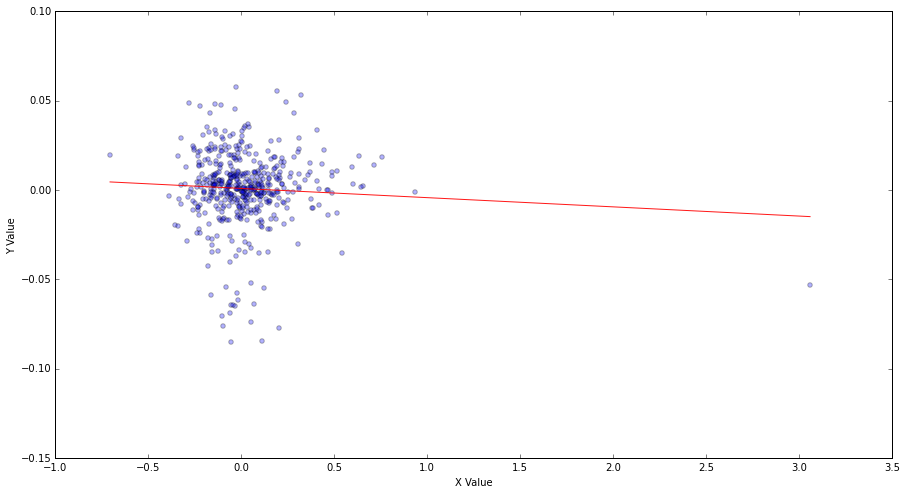

In [105]:
#OK 见证模型效果的时间到了 
model = linreg(SH_Vol_pct_change_noShift.values, SH_Close_change_1dayShift.values) #取出dataFrame的数值
print(model.summary())

OK.我们现在得到了一个模型和一堆统计名词以及数据，下面让我们一一搞明白这些名词是什么意思：

* R-square:对模型质量评价的数据。数值越大（0~1），模型的质量以及准确性就越高。
* Adj.R-square:虽然R-square可以评估模型的质量，但我们也可以通过增加更多有用或无用的变量去提升R-square，最终导致R-square完全没有意义。所以这里引入了Adj.R-square概念对过多的引入变量进行惩罚,是R-square更加准确。我们这里得到的数值是0.002，说明我们的自变量对因变量几乎没有任何解释效果。
* OLS: Ordinary Least Squares。线性回归计算系数的数学模型，这里就不过多解释了。
* F-statistic:  测试两组变量的期望值是否相同。如果F-statistic很小，或者prob（F-statistic）很大，说明两组数据很有可能出自同一总体，这组数据可用来测试的价值不高。
* Robustness:鲁棒性好的数据不会受异常值影响（图中飞出的两点）
* log-likihood, AIC, BIC:这些都是评估模型的数据。其中log-likelihood是数值越大越好，而AIC和BIC则是越小越好。我们在测试生存模型时用到log-likelyhood去计算系数，而在时间序列里，寻找最好的时间延迟时，用AIC或者BIC。
* Omnibus:测试你模型中被解释的方差是否大于未被解释的方差。
* Skew and Kurtosis:测量你数据分布图是否对称（skewness = 0），尖峰（Kurtosis>3)或者肥尾（Kurtosis < 3）
* Durbin-Watson:测试你数据的残值是否时间序列相关。（等于2则是无时间序列相关）
* Jarque-Bera (JB):测试你数据是否和正太分布相同。


解释完名词，让我们看看，我们模型具体得到了什么：

* const:模型中所提到的a。

* x1:模型中所提到的b。

* std err:我们系数的标准差

* t:student-T 测试值

* P值:
>对于每个系数，我们都有一个假设
>* 假设1:这个系数等于0（意思就是说这个系数没啥意义）
>* 假设2:这个系数不等于0
>任何一个假设都不是完全正确或是完全不正确。我们需要一个概率去评估。这个概率就是P值。
>P值代表了假设1成立的概率。所以p值越大，说明你的模型设计越白瞎...这就是为什么PHD会为 p << 0.05神魂颠倒了

* Conf Inter.:置信区间。既然模型系数是否成立是一个概率，那么模型的真实系数不应该是个固定值，而是隐藏在一个区间里，这个区间就是置信区间。

在这个模型里，const和x1的P值都远远大于0.05，只能说，如果你想用今天的上证指数的交易变化量去预测明天的股市涨跌，那结果只能是你会赔的很惨。


既然这组数据不能用线性表示，那我们就自己编组数据看看回归是怎样的：

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 2.442e+04
Date:                Thu, 31 Mar 2016   Prob (F-statistic):               0.00
Time:                        23:54:16   Log-Likelihood:                 204.54
No. Observations:                1000   AIC:                            -405.1
Df Residuals:                     998   BIC:                            -395.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0030      0.006      0.488      0.6

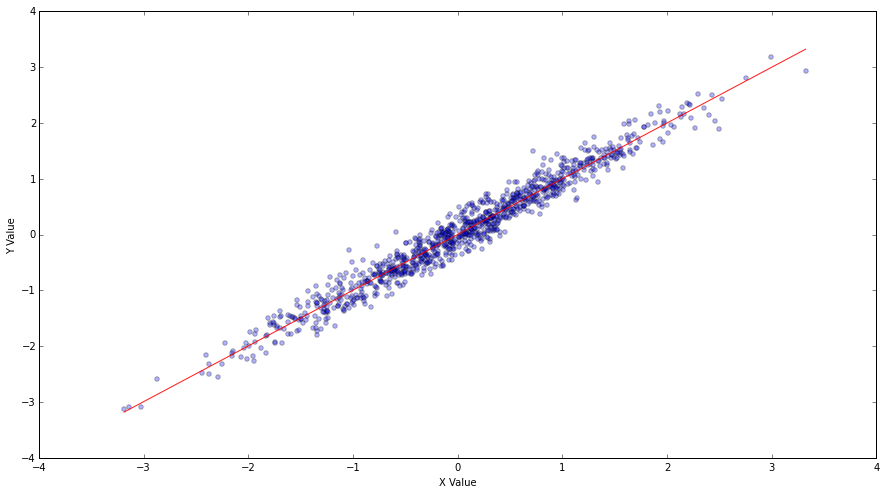

In [71]:
X = np.random.randn(1000)
Y = X + 0.2 * np.random.randn(1000)
model_2 = linreg(X,Y)
print(model_2.summary())

以上这组数据表现就好很多。我们得到的x1是0.9984，和我们的原始系数1很接近.

adj-R^2很高, 说明这个模型准确性很高。


回归还有几个假设是：
* 模型残值(residuals)符合正太分布
* 模型残值的方差是一定不变的。即使方差变化，必须是无序的。不能随时间改变而改变。

我们通过Anova表找到，模型残值是无时间序列的，下面我们看看残值的散点图和分布图：

残值的和是 -8.21565038223e-14


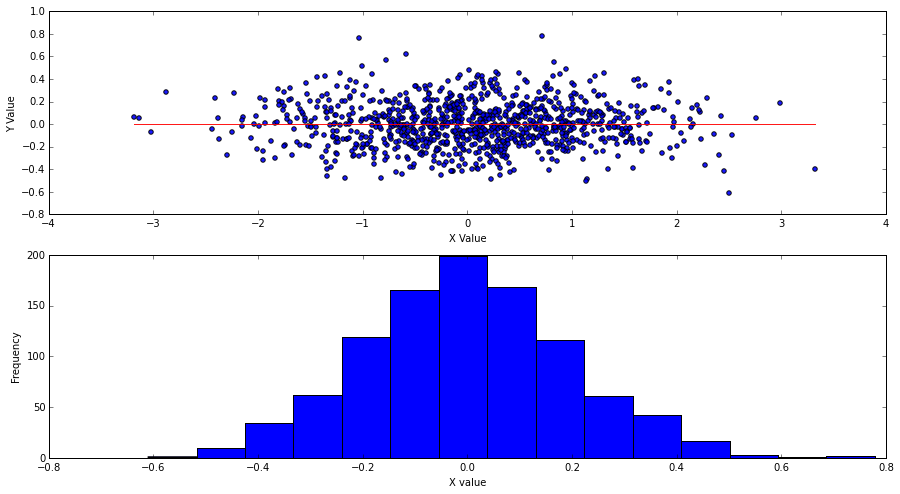

In [78]:
Yhat = model_2.params[0] + model_2.params[1] * X
residuals = Y - Yhat
plt.subplot(211)
plt.scatter(X, residuals,alpha=0.9);
Y_0 = np.zeros(1000)
plt.plot(X,Y_0, 'r', alpha = 0.9)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.gcf().set_size_inches(15,8)
plt.subplot(212)
plt.hist(residuals,bins=15)
plt.xlabel('X value')
plt.ylabel('Frequency')
print("残值的和是",residuals.sum())#残值的和几乎为0，符合正太分布

通过散点图可以发现残值均匀无序的分布在Y = 0的上下两边，而分布图是标准的正太分布（因为生成时就用的正太分布）
所以残值符合线性回归的假设。


下面我们再回过头来做我们金融方向的研究

抛开时间延迟，我们就想单纯看看中信证券的股票收益率和上证指数之间的关系

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     652.1
Date:                Fri, 01 Apr 2016   Prob (F-statistic):           7.60e-92
Time:                        00:46:13   Log-Likelihood:                 1156.0
No. Observations:                 488   AIC:                            -2308.
Df Residuals:                     486   BIC:                            -2300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0004      0.001      0.342      0.7

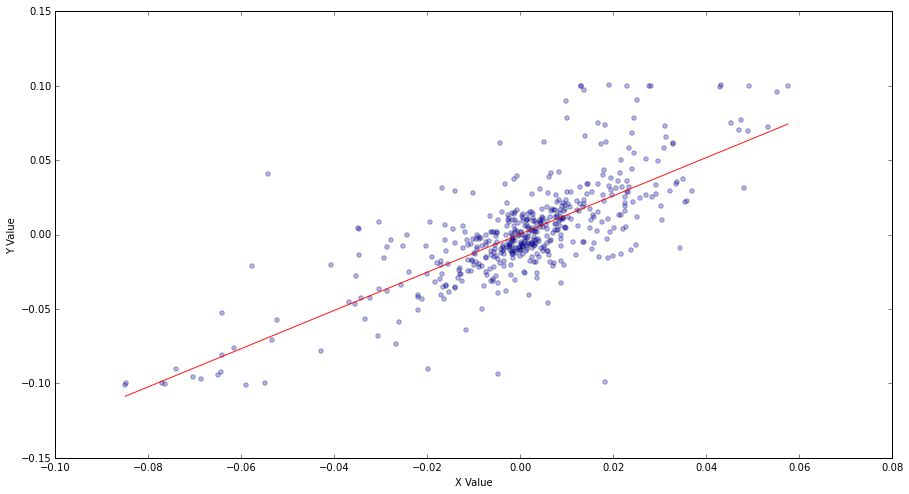

In [97]:
CIT = ts.get_hist_data('600030', start = start, end = end, ktype='D')
CIT_Close = CIT.close
CIT_Close = CIT_Close.iloc[::-1]
CIT_Close_pct_change = CIT_Close.pct_change()
CIT_Close_pct_change = CIT_Close_pct_change.dropna()
benchmark = SH_Close_pct_change
model_3 = linreg(benckmark.values, CIT_Close_pct_change.values)
print(model_3.summary())

残值的和是 -1.0269562977782698e-15


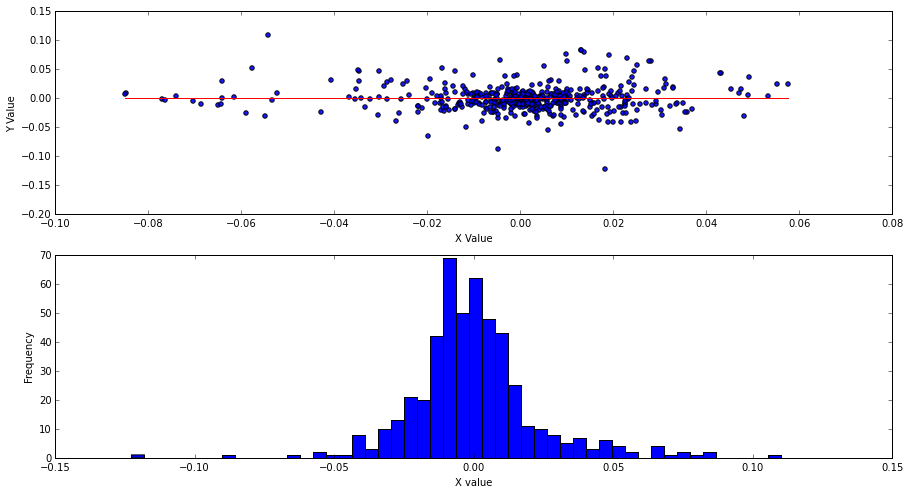

In [104]:
Y_hat_CIT = model_3.params[0] + model_3.params[1] * benchmark
residuals_CIT = CIT_Close_pct_change - Y_hat_CIT
#Plot
plt.subplot(211)
plt.scatter(benchmark, residuals_CIT,alpha=0.9);
Y_0 = np.zeros(len(benckmark))
plt.plot(benchmark, Y_0, 'r')
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.gcf().set_size_inches(15,8)
plt.subplot(212)
plt.hist(residuals_CIT,bins=50)
plt.xlabel('X value')
plt.ylabel('Frequency')
print("残值的和是",residuals_CIT.sum())

通过上图我们可以发现,如果没有时间延迟,则模型的表现会好很多,但这个模型只能简单的表达股票和市场之间的相关性。

如果想做预测,单纯用线性回归模型来测试国内的股票市场是远远不够的。